In [1]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [3]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

(8192,)


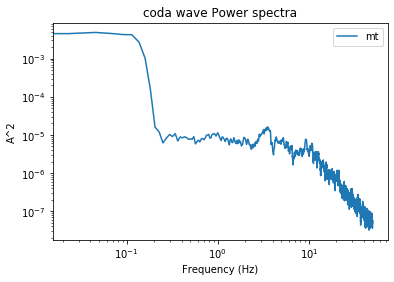

(8192,)


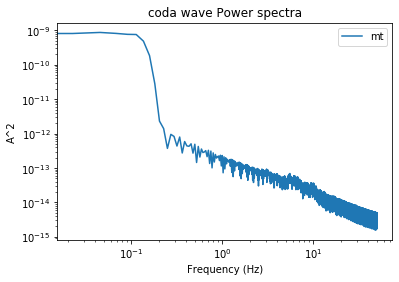

(8192,)


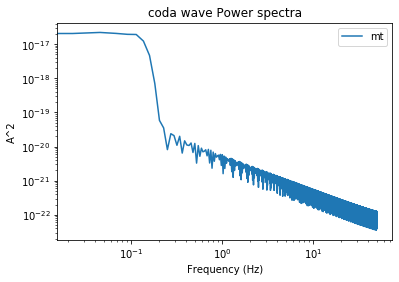

(8192,)


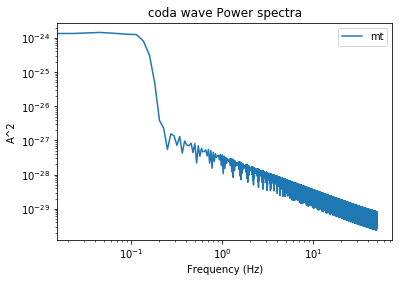

(8192,)


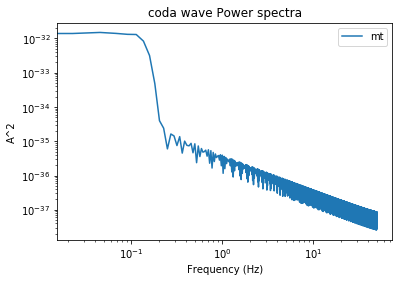

(8192,)


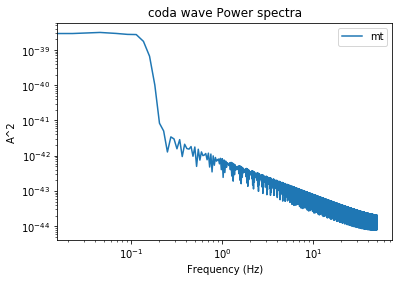

(8192,)


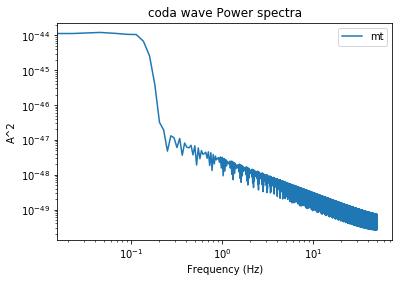

(8192,)


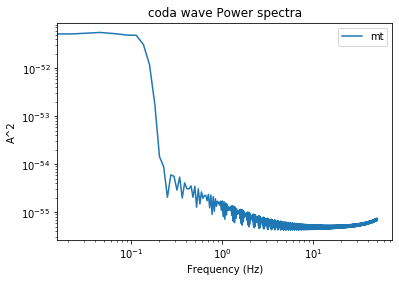

(8192,)


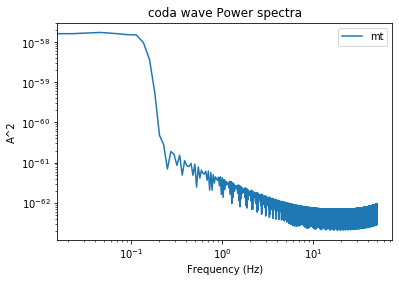

(8192,)


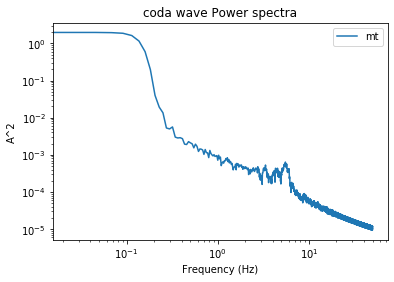

(8192,)


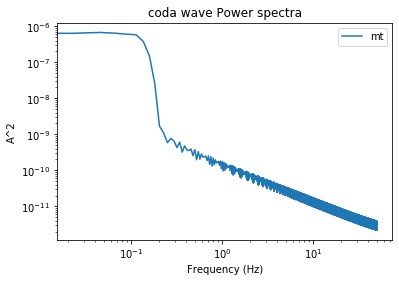

(8192,)


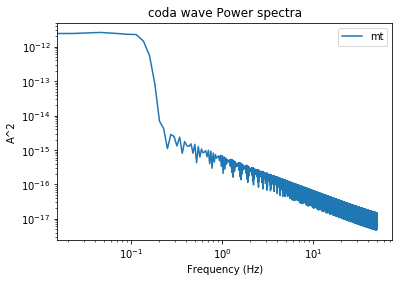

KeyError: 'XO.WD46.'

In [4]:
for eq_name in eq_with_data[0:10]:
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
    except: 
        break
    if len(data)>0:
        for tr_no in range(0, len(data)):
            
            #data.plot()
            inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
            data.remove_response(inv)
            with open(root+eq_name+'/picks.pkl', 'rb') as f:
                picks = pickle.load(f)
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            pick = UTCDateTime(picks[tr_name])
            start = int((pick - data[tr_no].stats.starttime)*sr)
            end = int(start + 4 * sr)
            d = data[tr_no].copy()#.filter('lowpass', freq=3)
            d.integrate()
            
            coda = signal.detrend(d)
            coda = d[start:end]
            nx = len(coda)
            hann = np.hanning(nx) #Is this the right sort of filter?
            nx2 = 2*nx
            x = np.zeros(nx2)

            x[0:nx] = coda*hann
            #plt.plot(x, label = 'x')
            dt = d.stats.delta

            #creating the frequencies to plot on x axis 
            Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

            #doing the multitaper to get the spectra 
            N = len(coda)
            NW=4.5
            k=5
            [tapers, eigen] = dpss(N, NW, k)
            freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
            freq = abs(freq_complex)
            freq = np.mean(freq,axis =0)
            freq_sdv = np.std(freq,axis =0)


            #plotting the spectra in loglog
            plt.loglog(Pfreq[:-1],freq[0:N//2], label='mt')
            #plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
            plt.xlabel('Frequency (Hz)');
            plt.ylabel('A^2');
            plt.title('coda wave Power spectra');
            plt.legend();

            Pfreq_MHZ = Pfreq
            freq_MHZ = freq 

            print(freq_MHZ.shape)
            plt.show()